In [1]:
using JuMP
using Ipopt
using DataFrames
import XLSX

abstract type Model end
struct Direct <: Model end
struct Migration <: Model end

In [2]:
#run = Direct();
run = Migration();

#These two are interdependent in the model and can be included in the future
#a1 = 1/3.4e7 # proportion of migrating squid, where 3.4E7 max(e^(tau-b1))
#K = 1208770.0 # carrying capacity in t
# If you clamp l1, l2, the values of E will be pushed higher.
# These are the only real constants
f = 40.0 # l of fuel per trip
B_h = 7.203 # hours per fisher
B_f = 2.0 # fisher per panga
m = 5492603.58 # cost per unit of transport all boats, MXN/trip
c_t = m*f # fleet cost of transport

### Initial values #############################################################
#Currently not in use
tau0 = 42.0 # temperature
q0 = 0.01 # squid catchability
y_S0 = 0.5 # proportion of migrated squid
R_tt0 = 0.5 # trader cooperation
S0 = 1208770.0 # size of the squid population
E0 = 1.0 # fishing effort
C0 = 120877.0 # squid catch
p_e0 = 164706.0 # max p_e comtrade
p_f0 = 15438.0 # max p_f datamares
R0 = C0*p_f0-(c_t+E0);

In [3]:
#df2 looks at 2001-2016, so df1 should only yield that set too
df1 = DataFrame(XLSX.readtable("./DATA/R3_data.xlsx", "Sheet1")...)
# load columns
y = Int64.(df1[:year][11:26]) #
#pe = Float64.(map(x->ismissing(x) ? NaN : x, df1[:pe_MXNiat][11:26])) #
pf = Float64.(df1[:pf_MXNiat][11:26]) #
#ct = Float64.(map(x->ismissing(x) ? NaN : x, df1[:C_t][11:26])) #
#ssh = Float64.(map(x->ismissing(x) ? NaN : x, df1[:essh_avg][11:26])) #
ml = Float64.(df1[:ML][11:26]) #
ys = map(x->parse(Float64,x),df1[:y_S][11:26]) #


df2 = dropmissing(DataFrame(XLSX.readtable("./DATA/PriceVolDataCorrected.xlsx", "Sheet1")...))
VolAll = Float64.(df2[:tons_DM]) ## CATCH DATA
PrAll = Float64.(df2[:priceMXNia_DM]) ## PRICE DATA 

### New max time
tmax = length(df2[:Year]);

In [4]:
model = JuMP.Model(solver = IpoptSolver(max_iter=1000,print_frequency_iter=500,sb="yes"));

In [5]:
@variable(model, b1, start=41.750) # isotherm depth (est)
@variable(model, b2, start=-5.696) # isotherm depth (est)
@variable(model, b3, start=16.397) # isotherm depth (est)
@variable(model, 0.0 <= beta <= 1.0) # slope of demand-price function
@variable(model, 1000.0 <= c_p <= 2148.0) # cost of processing, MXNia/t
@variable(model, 0.0 <= g <= 3.2) # population growth rate
@variable(model, 20000.0 <= gamma <= 51000.0) # maximum demand, t
#@variable(model, h1) # E scale
#@variable(model, h2) # E scale
@variable(model, l1, start = -0.0028) # q scale
@variable(model, l2, start = 0.1667) # q scale
#testing
@variable(model, a1, start=1/3.4e7)
@variable(model, K, start=1208770.0)

@variable(model, 20.0 <= tau[t=1:tmax] <= 80.0) # temperature
@variable(model, 4000.0 <= p_e[t=1:tmax] <= 100_000.0) # export price
@variable(model, q[t=1:tmax]) # catchability squid population
@variable(model, 0.0 <= y_S[t=1:tmax] <= 1.0) # Proportion of squid migration from initial fishing grounds
# c_t is per trip so we need to upscale E hr > fisher > trip
#@variable(model, Escal[t=1:tmax]) # fishing effort
@variable(model, 0.0 <= E[t=1:tmax] <= 1.0) # fishing effort
@variable(model, S[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(model, C[t=1:tmax]  >= 0.0) # squid catch 10% of S
@variable(model, p_f[t=1:tmax]) # price for fishers
@variable(model, match)

if typeof(run) == Migration
    @variable(model, 11_956_952.0 <= w_m <= 28_108_539.0) # min wage per hour all fleet
    @variable(model, 0.0 <= R_tt[t=1:tmax] <= 1.0) # trader cooperation
    @variable(model, p_min[t=1:tmax] >= 0.0) # minimum wage 28_000_000 NOTE: This is quite low it seems
end

@constraint(model, [t=1:tmax], tau[t] == b1+b2*cos.(t)+b3*sin.(t));
@NLconstraint(model, [t=1:tmax], p_e[t] == gamma*(C[t])^(-beta));
#@NLconstraint(model, [t=1:tmax-1], Escal[t+1] == E[t]+p_f[t]*C[t]-c_t*(E[t]/(B_h+B_f)));
#@constraint(model, [t=1:tmax], E[t] == h1*Escal[t]+h2);
@NLconstraint(model, [t=1:tmax-1], S[t+1] == S[t]+g*S[t]*(1-(S[t]/K))-C[t]);
@NLconstraint(model, [t=1:tmax], C[t] == q[t]*E[t]*S[t]);
@NLconstraint(model, [t=1:tmax], y_S[t] == a1*exp(tau[t]-b1));
@NLconstraint(model, [t=1:tmax], q[t] == l1*tau[t]+l2);
if typeof(run) == Direct
    #First Model
    @constraint(model, [t=1:tmax], p_f[t] == p_e[t]-c_p);
else
    #Second model
    @NLconstraint(model, [t=1:tmax], p_min[t] == (E[t]*w_m)/C[t]);
    @constraint(model, [t=1:tmax], R_tt[t] == 1-y_S[t]);
    @constraint(model, [t=1:tmax], p_f[t] == (p_e[t]-c_p)*(1-R_tt[t])+R_tt[t]*p_min[t]);
end

#@constraint(model, C[1] == VolAll[1]); # squid catch
#@constraint(model, p_f[1] == PrAll[1]); # max p_f datamares
# Initial conditions
#@constraint(model, tau[1] == tau0);  # temperature
#@constraint(model, p_e[1] == p_e0); # max p_e comtrade

#@constraint(model, R_tt[1] == R_tt0); # trader cooperation
#@constraint(model, q[1] == q0); # squid catchability
#@constraint(model, E[1] == E0); # fishing effort
#@constraint(model, S[1] == S0); # size of the squid population

#Minimise the Least Squares differences between our model and the data
@NLconstraint(model, match == sum(abs(p_f[t] - PrAll[t])^2+abs(C[t] - VolAll[t])^2 for t in 1:tmax));
@objective(model, Min, match);

In [6]:
solve(model)

:Error

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      668
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      602

Total number of variables............................:      173
                     variables with only lower bounds:       48
                variables with lower and upper bounds:       85
                     variables with only upper bounds:        0
Total number of equality constraints.................:      144
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

**TODO:** `ML` and `R` have been removed from the model but ultimately are required outputs.
They should be post-processed vectors.

In [7]:
using Plots

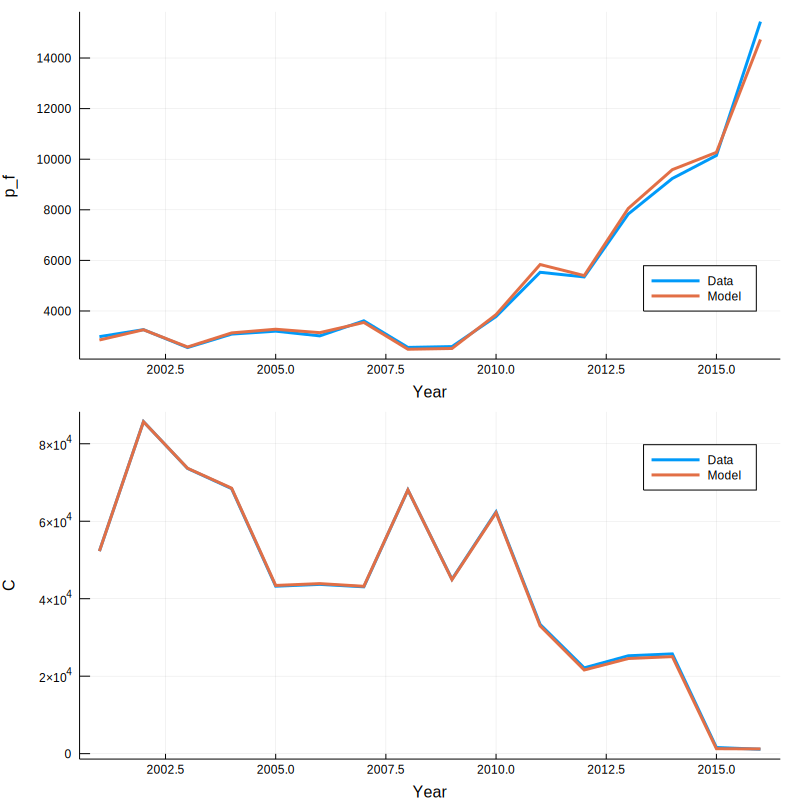

In [24]:
ha = plot(y, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:bottomright)
plot!(y, getvalue(p_f), label="Model")
hb = plot(y, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(y, getvalue(C), label="Model")
plot(ha,hb,linewidth=3,layout=(2,1),size=(800,800))

In [25]:
savefig("migration.png")

In [6]:
using LsqFit
using Plots

In [7]:
modpf(t,p) = p[1]*t.^(-p[2])-p[3]

modpf (generic function with 1 method)

In [8]:
xdata = 1:16
p0 = [30000.0, 0.1, 1500.0]

3-element Array{Float64,1}:
 30000.0
     0.1
  1500.0

In [9]:
fit = curve_fit(modpf, VolAll, PrAll, p0)

LsqFit.LsqFitResult{Float64,1}(13, [81126.8, 0.0505775, 43050.7], [794.067, -639.241, 420.463, 60.2963, 1029.53, 1190.16, 628.803, 598.799, 1541.71, -419.208, -673.878, 511.736, -2300.15, -3751.61, 2685.36, -1656.49], [0.577242 -5.08777e5 -1.0; 0.562989 -5.18793e5 -1.0; … ; 0.688845 -4.11845e5 -1.0; 0.700535 -399925.0 -1.0], false, Float64[])

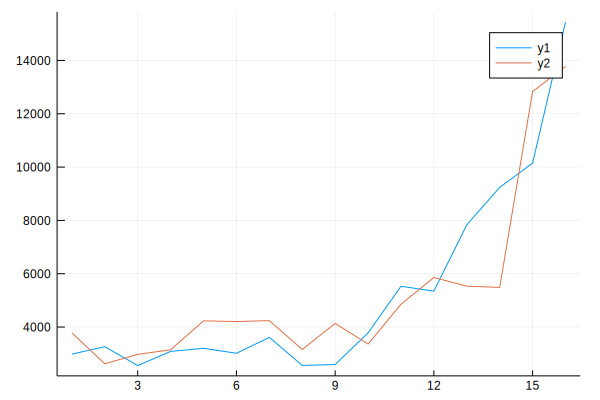

In [10]:
plot(PrAll)
plot!(modpf(VolAll,fit.param))

In [11]:
fit.param

3-element Array{Float64,1}:
 81126.8      
     0.0505775
 43050.7      

In [12]:
using DataFrames, CSV

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.6/CSV.ji for module CSV.


In [29]:
data = CSV.read("DATA/DailySSH.csv")
date = map(x->Date(x,"m/d/y"), data[:date]);
ssh = map(x->Float64(x), data[:SSH]);

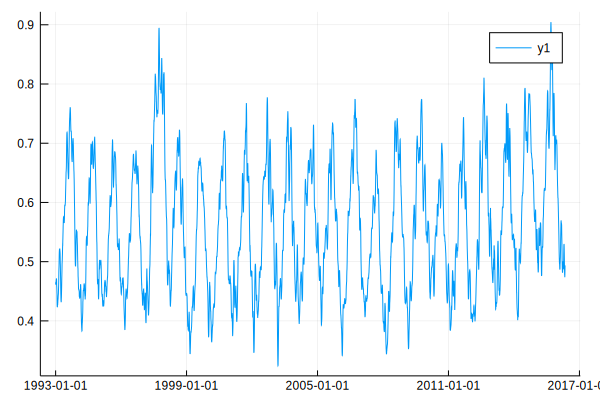

In [30]:
plot(date,ssh)

In [83]:
data = CSV.read("DATA/ctd_clean.csv")
dyear = map(x->Float64(x), data[5])
d22 = map(x->Float64(x), Missings.replace(data[:D_22], NaN))

580-element Array{Float64,1}:
 19.1783
 32.456 
 28.839 
 26.2376
 35.9068
 34.2473
 29.3536
 29.1094
 35.76  
 47.5092
 24.6256
 28.4368
 28.4833
  ⋮     
 23.0   
 27.4096
 28.1121
 35.1611
 42.0   
 42.0   
 41.0   
 41.0   
 35.4554
 35.4554
 41.5967
 41.5967

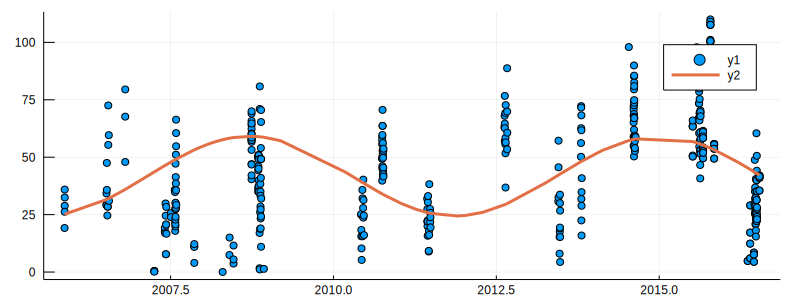

In [90]:
# This is a linear model fit for d22 = cos(t)+sin(t)+t where t=dyear from R.
scatter(dyear,d22, size=(800,300))
plot!(dyear, 41.75-5.696cos.(dyear)-16.379sin.(dyear), linewidth=3)

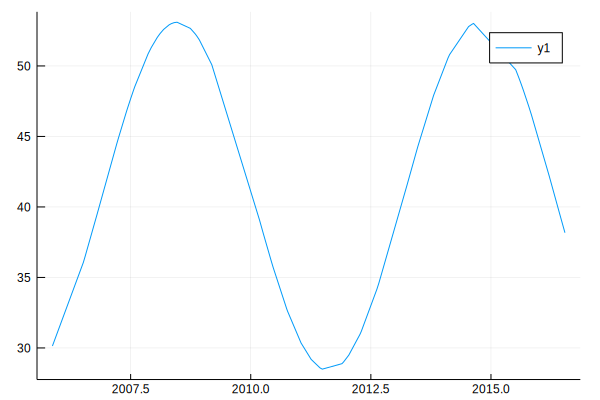

In [97]:
depth(t,p) = p[1]+p[2]*cos.(t)+p[3]*sin.(t)
p0 = [40.75, -6.696, -10.379]
fit = curve_fit(depth, dyear, d22, p0)
fit.param
plot(dyear,depth(dyear,fit.param))

In [99]:
estimate_errors(fit)

3-element Array{Float64,1}:
 NaN
 NaN
 NaN

In [82]:
data

,cruise,station,type,yyyy-mm-ddThh:mm,decimal_year,lonE,lonW,lat,day_of_yr,z_0,T_0,S_0,O_0,D_15,D_19,D_20,D_21,D_22,D_23,D_24,D_25,T_5,T_10,T_15,T_20,T_25,T_30,T_40,T_50,T_75,T_100,T_125,T_150,T_200,T_250,T_300,DO_20,DO_60
1,SR_Nov05,SR1,C,2005-11-14T11:24:00,2005.87,247.756,112.244,27.381,318,0.0,23.957,35.365,missing,89.555,32.0,28.0868,26.6918,19.1783,14.0,missing,missing,23.63,23.514,22.915,21.871,21.385,19.55,17.933,17.348,15.708,14.387,13.611,12.986,12.27,11.291,10.701,missing,missing
2,SR_Nov05,SR2,C,2005-11-15T08:34:00,2005.87,247.834,112.166,27.317,319,0.994,24.08,35.393,195.688,121.415,54.691,43.753,34.805,32.456,25.5318,13.923,missing,24.079,24.0751,23.9292,23.4625,23.1181,22.3151,20.5059,19.3088,17.1401,16.0279,14.7226,13.589,12.474,11.9375,10.828,213.825,103.634
3,SR_Nov05,SR3,C,2005-11-15T10:04:00,2005.87,247.82,112.18,27.315,319,2.983,23.715,35.537,172.814,113.092,43.753,38.658,36.5881,28.839,21.878,missing,missing,23.6804,23.5384,23.4399,23.2292,22.5277,21.7966,19.4828,18.3328,16.6257,15.6705,14.3735,13.545,12.5132,11.5798,missing,217.851,90.7154
4,SR_Nov05,SR4,B,2005-11-15T11:35:00,2005.87,247.811,112.189,27.312,319,0.995,23.994,33.118,127.617,120.3,38.3885,32.2151,30.1551,26.2376,15.5974,0.995,missing,23.6854,23.5187,23.101,22.531,22.2521,21.1006,18.7777,17.8052,16.396,15.323,14.5958,13.784,missing,missing,missing,185.236,81.2924
5,SR_Nov05,SR5,C,2005-11-15T14:36:00,2005.87,247.868,112.132,27.278,319,6.962,24.42,35.397,184.522,91.474,48.0204,44.1909,41.1437,35.9068,25.855,13.6158,missing,missing,24.275,23.8304,23.6282,23.1492,22.5966,21.208,18.8056,16.6086,14.5667,13.437,12.839,11.6353,10.456,9.785,180.881,80.7939
6,SR_July06,SR4,B,2006-07-07T14:00:00,2006.52,247.801,112.199,27.317,188,0.994,30.3,37.699,180.093,missing,67.0455,47.679,39.733,34.2473,28.4792,23.5911,21.77,30.2859,29.7199,28.629,26.7812,23.6272,22.8521,20.9869,20.011,18.5878,16.6918,15.7814,missing,missing,missing,missing,missing,missing
7,SR_July06,SR3,B,2006-07-07T16:03:00,2006.52,247.818,112.182,27.312,188,0.993,28.531,40.323,122.627,141.018,62.1093,43.706,38.3484,29.3536,25.827,19.7209,18.4173,28.6962,26.7198,26.3045,23.8422,23.0395,21.8206,20.7427,19.4256,18.0763,16.7435,15.8661,14.741,13.5777,missing,missing,missing,202.431
8,SR_July06,SR2,C,2006-07-07T17:04:00,2006.52,247.833,112.167,27.327,188,0.994,30.526,38.176,162.68,139.032,60.932,43.0462,37.747,29.1094,26.0236,22.1695,19.6195,29.4449,26.0174,25.5842,24.9457,23.1904,21.7022,20.4225,19.5902,17.8764,16.5593,15.4071,14.67,13.7936,12.75,11.023,295.827,213.725
9,PP_July06,PP1,C,2006-07-09T10:06:00,2006.52,247.673,112.327,27.564,190,0.993,30.213,38.871,125.957,153.923,65.7119,56.2522,46.686,35.76,32.6207,31.0502,28.4036,30.4812,28.8213,26.0457,25.3895,25.3048,24.6744,21.8244,20.6934,18.3733,17.0992,15.7555,15.05,13.8822,12.897,12.302,361.824,222.857
10,SR_July06,SR1,C,2006-07-09T14:33:00,2006.52,247.756,112.244,27.379,190,0.993,30.833,35.214,182.443,135.061,74.1252,63.8865,52.4442,47.5092,45.8784,43.3578,37.747,29.5133,28.7739,28.0842,27.8715,26.6316,25.8179,24.6647,21.5276,18.865,17.0206,15.5898,14.589,13.3602,12.57,11.404,285.355,170.484


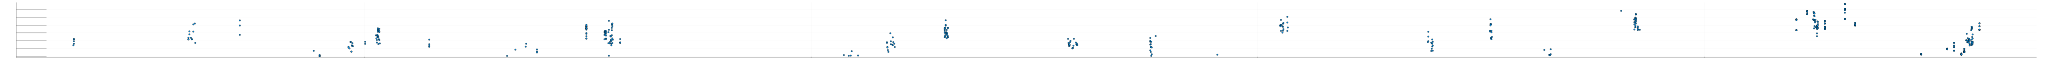

In [119]:
scatter(collect(Missings.replace(data[:decimal_year], NaN)), collect(Missings.replace(data[:D_20], NaN)), size=(10000,300))

In [260]:
# ~Round off~ truncate all data to some time period 
# (whilst we can round the date, it's better to truncate here since we'll be taking the mean)
time = map(date -> trunc(date, Dates.Year), data[4])

# Generate a vector with no missing timestamps
fulltime = collect(time[1]:Dates.Year(1):time[end])

# And the UT Instant while we're at it (for later)
dfulltime = map(date -> Dates.value(date), fulltime)

# Generate a matching vector for d22
fulld22 = fill!(Vector{Float64}(length(fulltime)), NaN)

# Identify positions of our rounded data in the complete vector
# Since we round, many values will have non-unique indexes
idxinfull = indexin(time,fulltime)

# Do work on every unique position
uidxinfull = unique(idxinfull)

for idx in uidxinfull
    # Backport to our rounded data
    position = find(fulltime[idx] .== time)
    # Insert mean of collected values into the complete vector,
    # ignoring any missing values in the original dataset.
    vals = collect(skipmissing(data[:D_22][position]))
    if length(vals) > 0
        fulld22[idx] = mean(vals)
    end
end;

In [261]:
df = DataFrame()
df[:date] = dfulltime
df[:d22] = fulld22
CSV.write("yearlyfull.csv", df)

CSV.Sink{Void,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false'
        internstrings: true, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "yearlyfull.csv", 9, true, String["date", "d22"], 2, false, Val{false})

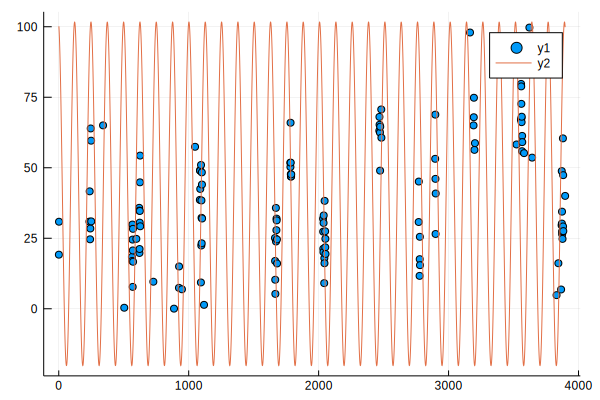

In [199]:
depth(t,p) = p[1]+p[2]*cos.(p[4]*t)+p[3]*sin.(p[4]*t)
p0 = [40.75, 60.0, -10.379, 0.05]
xlen = 1:length(fulld22)
fit = curve_fit(depth, xlen, fulld22, p0)
scatter(xlen,fulld22)
plot!(xlen,depth(xlen,fit.param))

In [200]:
fit.param

4-element Array{Float64,1}:
  40.75 
  60.0  
 -10.379
   0.05 

In [264]:
spline = CSV.read("cubic_spline.csv", datarow=1, header=["cubic"])
xint = CSV.read("x_spline.csv", datarow=1, header=["data"]);

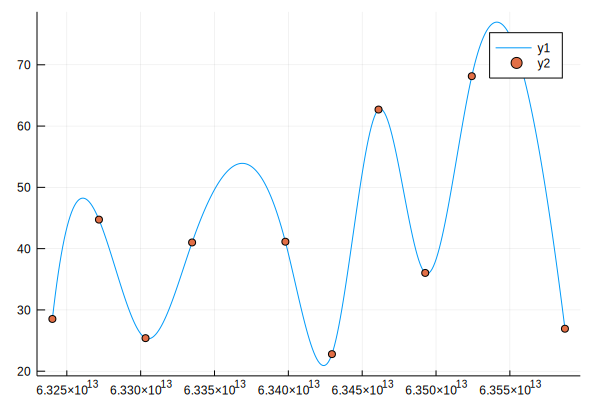

In [265]:
plot(xint[:data], spline[:cubic])
scatter!(dfulltime, fulld22)

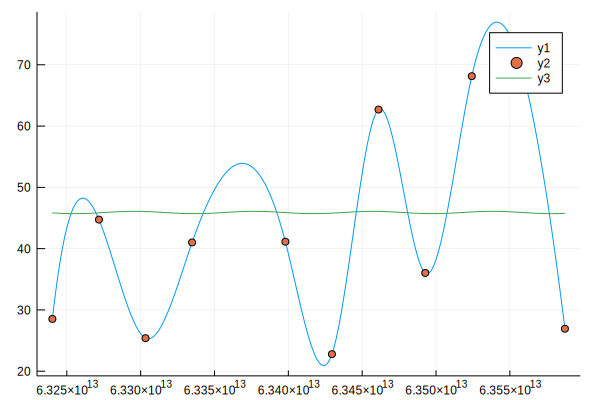

In [266]:
depthw(t,p) = p[1]+p[2]*cos.(p[4]*t)+p[3]*sin.(p[4]*t)
p0 = [40.75, -6.696, -10.379, 1.0]
fit = curve_fit(depthw, collect(skipmissing(xint[:data])), collect(skipmissing(spline[:cubic])), p0)
plot(xint[:data], spline[:cubic])
scatter!(dfulltime, fulld22)

plot!(collect(skipmissing(xint[:data])),depthw(collect(skipmissing(xint[:data])),fit.param))

In [270]:
extrema(collect(skipmissing(spline[:cubic])))

(20.91871325081479, 76.96480288394535)